In [30]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [31]:
import numpy as np
import pandas as pd

In [32]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [34]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [35]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [36]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [37]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [38]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [39]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [40]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [41]:
session = Session(engine)


In [46]:
import datetime

start_date = datetime.date(2019, 8, 4)
end_date = datetime.date(2019, 8, 18)

In [47]:
sample_dates = session.query(Measurement.date).limit(5).all()
for result in sample_dates:
    print(result)
    

('2010-01-01',)
('2010-01-02',)
('2010-01-03',)
('2010-01-04',)
('2010-01-06',)


In [49]:
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
max_date[0][0]

'2017-08-23'

In [56]:
precip_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8,23)).all()

In [57]:
precip_df = pd.DataFrame(precip_data, columns = ['date', 'precipitation'])

#index
precip_df.set_index('date', inplace = True)

#look at dataframe
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [53]:
precip_df = precip_df.sort_values(by = 'date')
precip_df.head()


,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


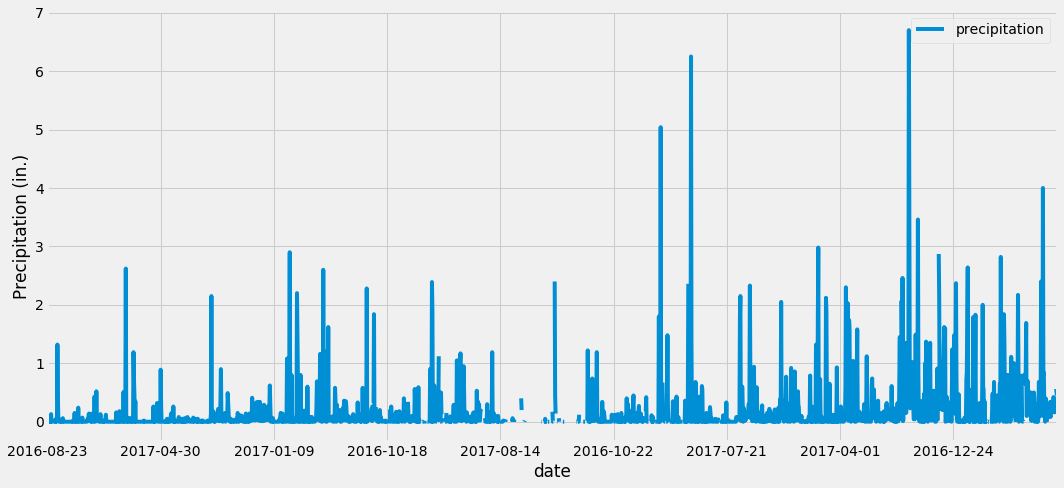

In [62]:
fig, ax = plt.subplots(figsize = (15, 7))
precip_df.plot(ax = ax, x_compat = True)

ax.set_ylabel('Precipitation (in.)')

plt.savefig("Images/precip.png")

plt.tight_layout()
plt.show()


In [63]:
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [66]:
num_of_station = session.query(Station.id).distinct().count()
num_of_station

9

In [72]:
station_counts = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in station_counts:
    print(f"Station: {result[0]}\tCount: {result[1]}")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [73]:
most_active_station = 'USC00519281'
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"Lowest Temperature: {summary_temps[0][0]} Fahrenheit")
print(f"Highest Temperature: {summary_temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2], 2)} Fahrenheit")

Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


In [74]:
yearly_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).all()

yearly_temps_df = pd.DataFrame(yearly_temps, columns = ['date', 'temperature'])
yearly_temps_df.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


In [75]:
yearly_temps_df.set_index('date', inplace = True)

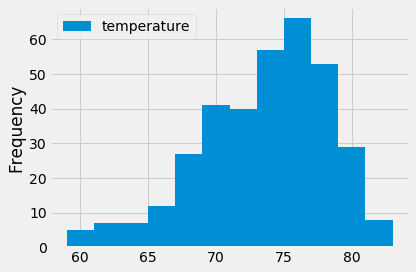

In [76]:
fig, ax = plt.subplots()
yearly_temps_df.plot.hist(bins = 12, ax = ax)

plt.savefig("Images/temphist.png")
plt.tight_layout()
plt.show()

In [87]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [90]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_temps = calc_temps('2017-08-04', '2017-08-18')

print(f"Lowest Temperature: {trip_temps[0][0]} Fahrenheit")
print(f"Average Temperature: {round(trip_temps[0][1], 2)} Fahrenheit")
print(f"Highest Temperature: {trip_temps[0][2]} Fahrenheit")


Lowest Temperature: 70.0 Fahrenheit
Average Temperature: 78.85 Fahrenheit
Highest Temperature: 84.0 Fahrenheit


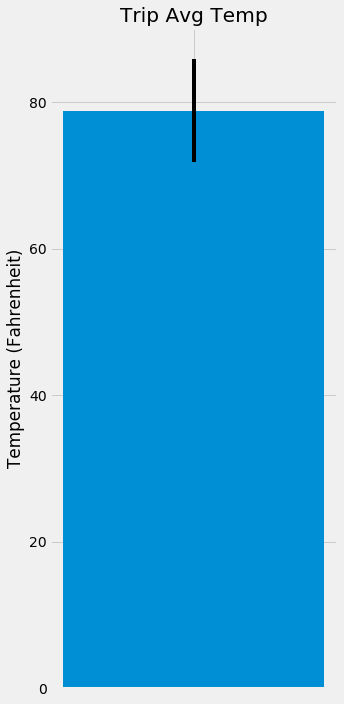

In [92]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
pk_to_pk = trip_temps[0][2] - trip_temps[0][0]
avg_temp = trip_temps[0][1]

fig, ax = plt.subplots(figsize = (5,10))
ax.bar(1, avg_temp, yerr = pk_to_pk/2, width = 0.4)

ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temperature (Fahrenheit)')

plt.tight_layout()
plt.show()

In [93]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

yearly_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                               Station.elevation, func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()

#load into a dataframe
yearly_rainfall_df = pd.DataFrame(yearly_rainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Avg. Precipitation (in.)'])

yearly_rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.450640
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125434
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121051
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.076500
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044819


## Optional Challenge Assignment

In [94]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [97]:
# calculate the daily normals for your trip
trip_dates = ["08-04", "08-05", "08-06", "08-07", "08-08", "08-09", "08-10", "08-11", "08-12", "08-13", "08-14",
             "08-15", "08-16", "08-17", "08-18"]

daily_norms = []

for trip_date in trip_dates:
    day = {}
    day['Date'] = f"2019-{trip_date}"
    daily_norm = daily_normals(trip_date)
    day['Min'] = daily_norm[0][0]
    day['Avg'] = daily_norm[0][1]
    day['Max'] = daily_norm[0][2]
    daily_norms.append(day)
    
daily_norms



[{'Date': '2019-08-04', 'Min': 69.0, 'Avg': 76.71153846153847, 'Max': 84.0},
 {'Date': '2019-08-05', 'Min': 69.0, 'Avg': 76.14814814814815, 'Max': 82.0},
 {'Date': '2019-08-06', 'Min': 67.0, 'Avg': 76.25, 'Max': 83.0},
 {'Date': '2019-08-07', 'Min': 71.0, 'Avg': 77.15686274509804, 'Max': 83.0},
 {'Date': '2019-08-08', 'Min': 68.0, 'Avg': 76.5576923076923, 'Max': 83.0},
 {'Date': '2019-08-09', 'Min': 69.0, 'Avg': 75.98039215686275, 'Max': 81.0},
 {'Date': '2019-08-10', 'Min': 65.0, 'Avg': 76.42, 'Max': 83.0},
 {'Date': '2019-08-11', 'Min': 67.0, 'Avg': 75.98113207547169, 'Max': 82.0},
 {'Date': '2019-08-12', 'Min': 67.0, 'Avg': 76.52727272727273, 'Max': 83.0},
 {'Date': '2019-08-13', 'Min': 71.0, 'Avg': 76.98245614035088, 'Max': 84.0},
 {'Date': '2019-08-14', 'Min': 71.0, 'Avg': 76.77777777777777, 'Max': 82.0},
 {'Date': '2019-08-15', 'Min': 69.0, 'Avg': 76.47169811320755, 'Max': 83.0},
 {'Date': '2019-08-16', 'Min': 69.0, 'Avg': 76.08, 'Max': 83.0},
 {'Date': '2019-08-17', 'Min': 69.0,

In [98]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df = pd.DataFrame(daily_norms)

daily_norms_df.set_index('Date', inplace = True)

daily_norms_df

,Avg,Max,Min
Date,,,
2019-08-04,76.711538,84.0,69.0
2019-08-05,76.148148,82.0,69.0
2019-08-06,76.250000,83.0,67.0
2019-08-07,77.156863,83.0,71.0
2019-08-08,76.557692,83.0,68.0
2019-08-09,75.980392,81.0,69.0
2019-08-10,76.420000,83.0,65.0
2019-08-11,75.981132,82.0,67.0
2019-08-12,76.527273,83.0,67.0


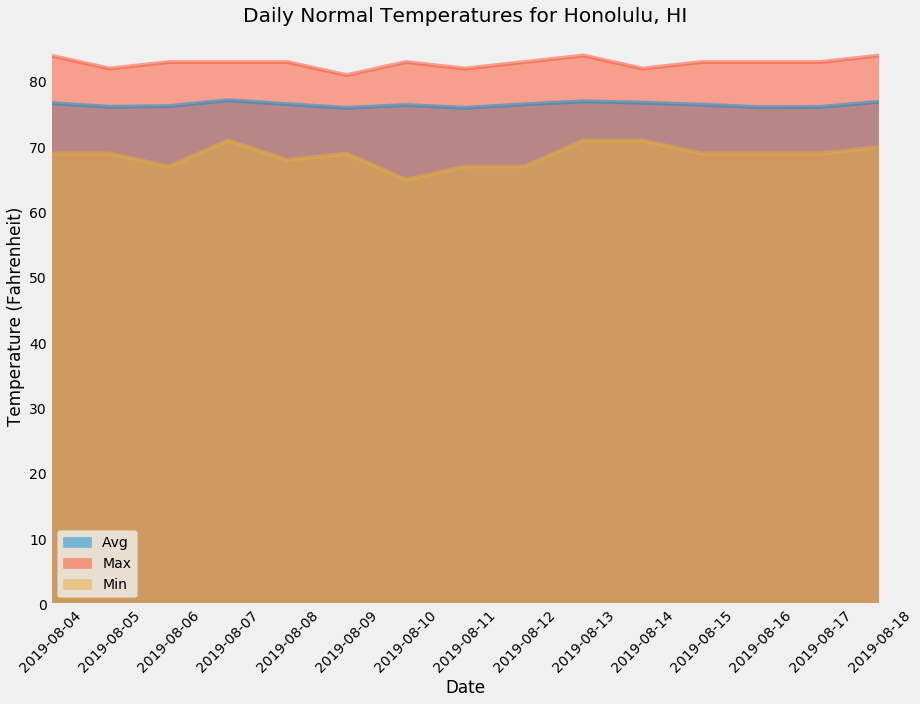

In [99]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize = (13, 10))
daily_norms_df.plot.area(ax = ax, stacked = False)

#set labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_title('Daily Normal Temperatures for Honolulu, HI')

#set ticks
dates = [f"2019-{trip_date}" for trip_date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation = 45)

#save figure
plt.savefig('Images/dailynormarea.png')

#show
plt.grid()
plt.tight_layout()
plt.show()